In [0]:
!mkdir -p ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d shadabhussain/flickr8k

100% 1.09G/1.09G [00:24<00:00, 45.5MB/s]
100% 1.09G/1.09G [00:24<00:00, 47.5MB/s]


In [0]:
!unzip -qq flickr8k.zip

In [0]:
!unzip -qq Flickr_Data.zip

In [0]:
import numpy as np

In [0]:
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense,Input,Dropout,Embedding,LSTM
from keras.layers.merge import add
import re

Using TensorFlow backend.


In [0]:
#read captions
def readtext(path):
    with open(path) as f:
        captions=f.read()
    return captions

In [0]:
captions=readtext('Flickr_Data/Flickr_TextData/Flickr8k.token.txt')
captions=captions.split('\n')[:-1]

In [0]:
captions[-1]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

In [0]:
print(captions[0])
print(captions[0].split('\t'))

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
['1000268201_693b08cb0e.jpg#0', 'A child in a pink dress is climbing up a set of stairs in an entry way .']


In [0]:
#dictionary to map image to caption
descriptions={}

for x in captions:
    fp,sp= x.split('\t')
    im_name=fp.split('.')[0]
    
    if descriptions.get(im_name) is None:
        descriptions[im_name]=[]
    descriptions[im_name].append(sp)

In [0]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [0]:
import cv2
import matplotlib.pyplot as plt

In [0]:
im=cv2.imread('Flickr_Data/Images/1000268201_693b08cb0e.jpg')
im=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

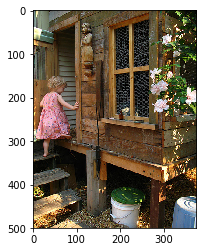

In [0]:
plt.imshow(im)
plt.show()

In [0]:
#data cleaning
import re

In [0]:
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub('[^a-z]+',' ',sentence)
    sentence=sentence.split()
    
    sentence=[s for s in sentence if len(s)>1]
    sentence=' '.join(sentence)
    return sentence

In [0]:
clean_text('A cat is sitting over house # 65')

'cat is sitting over house'

In [0]:
#clean all captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [0]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [0]:
#write data to text file
with open('descriptions_1.txt','w') as f:
    f.write(str(descriptions))

In [0]:
import json

In [0]:
descriptions=None
with open('descriptions_1.txt','r') as f:
    descriptions=f.read()
json_acceptable_string = descriptions.replace("'","\"")
descriptions=json.loads(json_acceptable_string)

In [0]:
print(type(descriptions))

<class 'dict'>


In [0]:
vocab=set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print("vocab size : %d"%len(vocab))

vocab size : 8424


In [0]:
#total words across all sentence
total=[]
for key in descriptions.keys():
    [total.append(i) for des in descriptions[key] for i in des.split()]
print("toatl words : %d"%len(total))

toatl words : 373837


In [0]:
print(total[:10])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']


In [0]:
import collections

In [0]:
counter=collections.Counter(total)
print(type(counter))
freq_count=dict(counter)
# print(freq_count)
print(len(freq_count.keys()))  #no of unique words

<class 'collections.Counter'>
8424


In [0]:
# sort as per freq_count
sorted_freq_count=sorted(freq_count.items(),reverse=True,key=lambda x:x[1])
#filter
threshold=10
sorted_freq_count=[x for x in sorted_freq_count if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_count]

In [0]:
print("no of total usable words : %d"%len(total_words))

no of total usable words : 1845


In [0]:
##preparing taining/test data
training_file_data=readtext('Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt')
test_file_data=readtext('Flickr_Data/Flickr_TextData//Flickr_8k.testImages.txt')
train=[row.split('.')[0] for row in training_file_data.split('\n')[:-1]]
test=[row.split('.')[0] for row in test_file_data.split('\n')[:-1]]

In [0]:
print(train[:10])
print(test[:10])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154']
['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01', '2654514044_a70a6e2c21', '2339106348_2df90aa6a9', '256085101_2c2617c5d0', '280706862_14c30d734a', '3072172967_630e9c69d0']


In [0]:
#prepare descriptions for the training data
#add <s> and <e> token to training data.
train_descriptions={}
for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append='startseq '+cap+' endseq'
        train_descriptions[img_id].append(cap_to_append)

In [0]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [0]:
model=ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()








102858752/102853048 [==============================] - 8s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_________________

In [0]:
#custome transfer learing model
model_new=Model(model.input,model.layers[-2].output)

In [0]:
model.layers[-2]

In [0]:
# #feature extraction from the images and store them. as we dont want to calculate them
# repeatedly

In [0]:
def preprocess_img(img):
  img=image.load_img(img,target_size=(224,224))
  img=image.img_to_array(img)
  img=np.expand_dims(img,axis=0)
  #normalization
  img=preprocess_input(img)#used for normalization
  return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


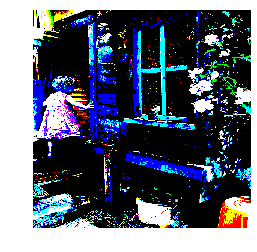

In [0]:
img=image.load_img('Flickr_Data/Images/1000268201_693b08cb0e.jpg',target_size=(224,224))
#plt.imshow(img)
img=image.img_to_array(img)
img=np.expand_dims(img,axis=0)
#normalization
img=preprocess_input(img)
plt.imshow(img[0])
plt.axis('off')
plt.show()

In [0]:
def encode_img(img):
  img = preprocess_img(img)
  feature_vector=model_new.predict(img)
  #print(feature_vector.shape)
  feature_vector = feature_vector.reshape((-1,))
  return feature_vector

In [0]:
encode_img('Flickr_Data/Images/1000268201_693b08cb0e.jpg')

array([0.04154311, 0.17076056, 0.29278564, ..., 0.05089615, 0.31322354,
       0.8600749 ], dtype=float32)

In [0]:
#iterate over all images
start_time=time()
encoding_train={}#image_id-> feature vector over all images
for ix,img_id in enumerate(train):
  img_path='Flickr_Data/Images'+'/'+img_id+'.jpg'
  encoding_train[img_id]=encode_img(img_path)
  if ix%100==0:
    print('encoding in progress %d: '%ix)
end_time=time()
print('total time elapsed : ',(end_time-start_time))

encoding in progress 0: 
encoding in progress 100: 
encoding in progress 200: 
encoding in progress 300: 
encoding in progress 400: 
encoding in progress 500: 
encoding in progress 600: 
encoding in progress 700: 
encoding in progress 800: 
encoding in progress 900: 
encoding in progress 1000: 
encoding in progress 1100: 
encoding in progress 1200: 
encoding in progress 1300: 
encoding in progress 1400: 
encoding in progress 1500: 
encoding in progress 1600: 
encoding in progress 1700: 
encoding in progress 1800: 
encoding in progress 1900: 
encoding in progress 2000: 
encoding in progress 2100: 
encoding in progress 2200: 
encoding in progress 2300: 
encoding in progress 2400: 
encoding in progress 2500: 
encoding in progress 2600: 
encoding in progress 2700: 
encoding in progress 2800: 
encoding in progress 2900: 
encoding in progress 3000: 
encoding in progress 3100: 
encoding in progress 3200: 
encoding in progress 3300: 
encoding in progress 3400: 
encoding in progress 3500: 
enco

In [0]:
#store all the image into a file as it taken too much time
with open('encodes_train_features.pkl','wb') as f:
  pickle.dump(encoding_train,f)

In [0]:
#iterate over all test images
start_time=time()
encoding_test={}#image_id-> feature vector over all images
for ix,img_id in enumerate(test):
  img_path='Flickr_Data/Images'+'/'+img_id+'.jpg'
  encoding_test[img_id]=encode_img(img_path)
  if ix%100==0:
    print(' Test encoding in progress : %d '%ix)
end_time=time()
print('total time consumed : %f seconds'%(end_time-start_time))

 Test encoding in progress : 0 
 Test encoding in progress : 100 
 Test encoding in progress : 200 
 Test encoding in progress : 300 
 Test encoding in progress : 400 
 Test encoding in progress : 500 
 Test encoding in progress : 600 
 Test encoding in progress : 700 
 Test encoding in progress : 800 
 Test encoding in progress : 900 
total time consumed : 33.952626 seconds


In [0]:
#store all the image into a file as it taken too much time for test too
with open('encodes_test_features.pkl','wb') as ft:
  pickle.dump(encoding_test,ft)

preprocessing ***captions***

In [0]:
#vocab
len(total_words)

1845

In [0]:
word_to_idx={}
idx_to_word={}
for i,word in enumerate(total_words):
  word_to_idx[word]=i+1
  idx_to_word[i+1]=word

In [0]:
print(word_to_idx['dog'])
print(idx_to_word[6])
print(len(idx_to_word))

6
dog
1845


In [0]:
#two special words ie start and end sequence token
idx_to_word[1846]='startseq'
word_to_idx['startseq']=1846
idx_to_word[1847]='endseq'
word_to_idx['endseq']=1847
vocab_size=len(word_to_idx)+1
print(vocab_size)

1848


In [0]:
max_len=0
for key in train_descriptions.keys():
  for cap in train_descriptions[key]:
    max_len=max(max_len,len(cap.split()))
print(max_len)

35


data loader(***generator***)

In [0]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
  X1,X2,y=[],[],[]
  n=0
  while True:
    for key,desc_list in train_descriptions.items():
      n+=1
      photo=encoding_train[key+'.jpg']
      for desc in desc_list:
        seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
        for i in range(1,len(seq)):
          xi=seq[0:i]
          yi=seq[i] 
          #providing padding to the input sequence
          xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
          yi=to_categorical([yi],num_classes=vocab_size)[0]
          
          X1.append(photo)
          X2.append(xi)
          y.append(yi)
        
        if n==batch_size:
          yield[[np.array(X1),np.array(X2),np.array(y)]]
          X1,X2,y=[],[],[]
          n=0
          
  
  
  

WORD ***EMBEDDINGS***

In [0]:
#download the glove.6b.50d.txt embedding file comtaining 5oD vector for each word
!kaggle datasets download -d watts2/glove6b50dtxt

 90% 61.0M/67.7M [00:01<00:00, 22.8MB/s]
100% 67.7M/67.7M [00:01<00:00, 39.0MB/s]


In [0]:
!unzip -qq glove6b50dtxt.zip

In [0]:
f=open('glove.6B.50d.txt',encoding='utf8')

In [0]:
embedding_index={}
for line in f:
  values=line.split()
  word=values[0]
  word_embedding = np.array(values[1:],dtype='float')
  embedding_index[word] = word_embedding
  

In [0]:
f.close()

In [0]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [0]:
def get_embedding_matrix():
  emb_dim=50
  matrix=np.zeros((vocab_size,emb_dim))
  for word,idx in word_to_idx.items():
    embedding_vector=embedding_index.get(word)
    
    if embedding_vector is not None:
      matrix[idx]=embedding_vector
    
  return matrix
      
      

In [0]:
embedding_matrix=get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [0]:
embedding_matrix[1844]

array([ 0.26502  ,  0.62739  , -0.71265  , -1.2789   ,  0.91269  ,
        0.51781  ,  0.48637  , -0.5749   , -0.72425  , -0.50087  ,
       -0.56116  , -0.08708  ,  0.11522  ,  0.25907  ,  1.0899   ,
       -0.63988  , -1.209    , -0.63168  ,  0.43857  , -0.29447  ,
       -0.026305 , -0.12564  ,  0.60269  ,  0.54817  , -0.71601  ,
        0.76978  , -0.85958  ,  0.068224 , -0.40723  , -0.9634   ,
       -0.65194  ,  2.1013   ,  0.12377  ,  0.64811  ,  0.33728  ,
        0.49042  ,  0.15113  ,  0.039182 , -0.88092  , -0.77949  ,
       -0.30611  , -0.33116  ,  0.16673  ,  0.14939  ,  0.28773  ,
       -1.0608   ,  0.57765  , -0.69271  ,  0.40017  , -0.0097919])

MODEL **ARCHITECTURE**

In [0]:
#feature vector of images to a smaller vector
input_img_features=Input(shape=(2048,))
#do some changings
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#captions as input and to lower dim vector
input_captions=Input(shape=(max_len,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
#adding inputs and decode them
decoder1=add([inp_img2,inp_cap3])#adding two tensors
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

In [0]:
model=Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
#imporatnt thing is pre-initializing the embedding layers
model.layers[2].set_weights=([embedding_matrix])
model.layers[2].trainable=False

In [0]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

training the model....gonna be tough for time

In [0]:
!mkdir model_weights

In [0]:
epochs = 20
batch_size=3
#steps=len(train_descriptions)//number_pics_per_batch

In [0]:
def train():
  for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=20,verbose=1)
    model.save('model_weights/model_'+str(i)+'.h5')

In [0]:
train()

In [0]:
encoding_train['2513260012_03d33305cf']

array([0.28047323, 0.4068747 , 0.08380002, ..., 0.910792  , 0.04341809,
       0.09577889], dtype=float32)

In [0]:
model=load_model('model_weights.h5')

In [0]:
k